# 추론 기반 기법과 신경망


## 통계 기반 기법의 문제점

통계 기반 기법의 문제점은 대규모 말뭉치를 다룰 때 $O(n^3)$의 비용이 든다는 점

- `통계 기반 기법` : 학습 데이터를 한꺼번에 처리 (배치 학습)
- `추론 기반 기법`: 학습 데이터의 일부를 사용하여 순차적으로 학습(미니배치 학습)

미니배치 학습은 계산량이 큰 작업을 처리할 때 효율적. 데이터를 작게 나눠 학습하기 때문에 연산 가능. 또한 병렬 계산도 가능하게 하여 학습 속도 또한 높일 수 있다.

## 추론 기반 기법 개요
```
you ? goodbye and I say hello.
```
문장에서 ?을 추론하는 작업. 모델은 이러한 추론 문제를 반복해서 풀면서 **단어의 출현 패턴을 학습**한다.

## 신경망에서의 단어 처리

신경망을 이용해 단어를 처리하기 위해서는 단어를 **고정 길이의 벡터**로 변환해야 한다.

대표적인 방법이 `원핫 표현 (one-hot encoding)`

입력층의 각 뉴런이 각 단어에 대응됨

In [ ]:
# 완전연결계층에 의한 원핫 인코딩 형식의 단어 변환
# 7 X 3 계층, bias는 생략됨
import numpy as np

c = np.array([1, 0, 0, 0, 0, 0, 0]) # 원 핫 입력
W = np.random.randn(7,3) # 가중치
h = np.matmul(c,W) # 중간 노드
print(h)

원핫 표현의 단어 ID에 대응하는 원소만 1이고 그 외에는 0인 벡터.

즉, c와 W의 행렬 곱은 **가중치의 행벡터 하나**를 뽑아낸 것과 같다.

때문에 비효율적인 계산 방식. (4장에서 개선)

# 단순한 word2vec

## CBOW 모델의 추론 처리

CBOW <sup>continuous bag-of-words<sup>
    
CBOW 모델은 **맥락으로부터 타깃(target)을 추측**하는 용도의 신경망이다. 

- 타깃 : 중앙 단어
- 맥락 : 중앙 단어의 주변 단어들

<u>맥락이 입력이고 타깃이 출력이다</u>

<img src="../imgs/CBOW.png" width="300" align='left'>

위 그림을 보면 입력층이 4개 있고, 은닉층을 거쳐 출력층에 도달한다. 

4개의 입력층에서 은닉층으로의 변환은 완전연결계층 $W_{in}$ 이 처리한다. 

그리고 은닉층에서 출력층 뉴런으로의 변환은 다른 완전연결계층 $W_{out}$이 처리한다. 

위 그림에서 입력층이 4개인 이유는 맥락으로 고려할 단어를 4개로 정했기 때문. 

---

- 입력층 : 맥락에 포함시킬 단어가 N개라면 입력층도 N개이다.
<br></br><br></br>
- 은닉층 : 입력층의 여러개를 평균낸 값
<br></br><br></br>
- 출력층 : 뉴런의 개수 총 7개. 뉴런 하나하나가 각각의 단어에 대응된다. **출력층 뉴런은 각 단어의 '점수'를 뜻하며 값이 높을수록 대응 단어의 출현 확률도 높아진다.** 여기서 점수란 확률로 해석되기 전 값이고, 이 점수에 소프트맥수를 적용해서 확률을 얻을 수 있다.

---

입력층에서 은닉층으로의 변환을 완전연결계층 (가중치 $W_{in}$)이 처리한다. 

이때, (input이 7단어이고 hidden이 3개의 노드를 가질 때) 완전연결계층의 **가중치 $W_{in}$은 $7X3$ 행렬이며, <u>이 가중치의 각 행이 해당 단어의 분산 표현!</u>**

        you - 0 0 0
        say - 0 0 0
    goodbye - 0 0 0
        and - 0 0 0
          I - 0 0 0
      hello - 0 0 0
          . - 0 0 0 
          
따라서 **학습을 진행할수록 맥락에서 출현하는 단어(target)를 잘 추측하는 방향으로 이 분산 표현들이 갱신**될 것


In [ ]:
## CBOW 모델의 추론 처리, 맥락 2개 모델

import sys
sys.path.append('..')
import numpy as np
from common_wj.layers import MatMul

# 샘플 맥락 데이터 
c0 = np.array([1,0,0,0,0,0,0])
c1 = np.array([0,0,1,0,0,0,0])

# 가중치 초기화
W_in = np.random.randn(7,3)
W_out = np.random.randn(3,7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in) # 가중치 W_in을 공유한다
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h) # 각 단어의 점수 계산

print(s)

## CBOW 모델의 학습

CBOW 모델은 출력층에서 각 단어의 점수를 출력했다. 이 점수에 소프트맥스 함수를 적용하면 **확률**을 얻을 수 있는데, 

이 확률은 <u>맥락 (전후 단어)이 주어졌었을 때 그 중앙에 어떤 단어가 출현하는 지 </u>를 나타낸다.

CBOW의 학습에서는 올바른 예측을 할 수 있도록 가중치를 조정하는 일을 한다. 

그 결과, 가중치 $W_{in}$ (또한 $W_{out}$ 에도) 에 **단어의 출현 패턴을 파악한 벡터가 학습**된다.

이후 소프트맥스와 교차 엔트로피 오차를 통해 손실을 얻어 학습에 사용함.

## word2vec의 가중치와 분산 표현

입력 측 완전연결계층의 가중치 ($W_{in}$)와 출력 측 완전연결계층의 가중치 ($W_{out}$) 둘 다 각 단어의 분산 표현을 가지고 있다.

BUT $W_{out}$에는 단어의 분산표현이 열 방향(수직 방향)으로 저장된다.

$W_{in} = 7X3, W_{out} = 3X7$ 

이때 우리가 활용할 수 있는 선택지는 다음의 세 가지가 있다.

- A. 입력 측의 가중치만 이용
- B. 출력 측의 가중치만 이용
- C. 양쪽 가중치 모두 이용 

**A안인 입력 측 가중치만 이용하는 것이 보편적 방안이다.**

(참고) GloVe에서는 두 가중치를 더했을 때 더 좋은 결과를 얻음

# 학습 데이터 준비

"You say goodbye and I say hello."

## 맥락과 타깃

맥락은 타깃의 주변 단어로, 여러 단어가 될 수 있다.

이때 맨 끝 단어는 고려하지 않음

In [ ]:
import sys
sys.path.append('..')
from common_wj.util import preprocess

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)
print(id_to_word)

In [ ]:
def create_contexts_target(corpus, window_size = 1):
    
    target = corpus[window_size:-window_size] # 맥락의 개수가 채워지지 않는 양 끝 단어는 제외
    contexts = []

    for idx in range(window_size, len(corpus) - window_size):
        cs = [] # context_per_target
        for t in range(-window_size,window_size + 1): # target=0을 기준으로 window_size만큼 좌우 
            if t == 0:
                continue
            cs.append(corpus[idx + t])

        contexts.append(cs)

    return np.array(contexts), np.array(target)

In [ ]:
contexts, target = create_contexts_target(corpus,)

print(contexts) #
print("맥락의 형상:",contexts.shape,'\n')
print(target)
print("타깃의 형상:",target.shape)

## 원핫 표현으로 변환

In [ ]:
def convert_one_hot(corpus, vocab_size):
    
    '''one-hot encoding 으로 변환 
    
    param corpus: 단어 ID목록(1차원 혹은 2차원의 NumPy배열)
    param vocab_size: 어휘수(unique)
    :return:one-hot표현(2차원 혹은 3차원의 NumPy배열)
    ''' 
    N = corpus.shape[0]
    
    if corpus.ndim == 1: # target
        one_hot = np.zeros((N, vocab_size), dtype = np.int32) # unique한 어휘 개수로 one hot length 부여됨.
        for idx, word_id in enumerate(corpus):
            one_hot[idx, word_id] = 1 # 한 단어 당 하나의 one-hot
            
    elif corpus.ndim == 2: # contexts
        C = corpus.shape[1]
        one_hot = np.zeros((N, C, vocab_size), dtype = np.int32)
        for idx_0, word_ids in enumerate(corpus):
            for idx_1, word_id in enumerate(word_ids): # word_id 개수만큼 다시 반복분돌기
                one_hot[idx_0,idx_1,word_id] = 1
                
    return one_hot

In [ ]:
print(target)
convert_one_hot(target, 7)

In [ ]:
print(contexts)
convert_one_hot(contexts, 7)

In [ ]:
import sys
sys.path.append('..')
from common_wj.util import preprocess, create_contexts_target, convert_one_hot

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size = 1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

# CBOW 모델 구현

In [ ]:
import sys
sys.path.append('..')
import numpy as np
from common_wj.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size # 인수로 어휘 수와 은닉층의 뉴런 수를 받는다.
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f') # 32비트 부동소수점 수
        W_out = 0.01 * np.random.randn(H, V).astype('f')
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in) # W_in은 contexts의 개수만큼 생성 (즉, window_size*2 만큼 생성)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모은다.
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장한다.
        self.word_vecs = W_in
        
    def forward(self, contexts, target): # 인수로 맥락과 타깃을 받아서 loss를 반환
        # contexts.shape = (6, 2, 7), target.shape = (6, 7)
        h0 = self.in_layer0.forward(contexts[:,0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

## 학습 코드 구현

| epoch 1 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 2 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 3 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 4 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 5 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 6 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 7 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 8 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 9 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 10 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 11 |  iter 1 / 2 | time 0[s] | loss 1.95
| epoch 12 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 13 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 14 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 15 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 16 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 17 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 18 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 19 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 20 |  iter 1 / 2 | time 0[s] | loss 1.94
| epoch 21 |  iter 1 / 2 | ti

| epoch 228 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 229 |  iter 1 / 2 | time 0[s] | loss 1.15
| epoch 230 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 231 |  iter 1 / 2 | time 0[s] | loss 1.19
| epoch 232 |  iter 1 / 2 | time 0[s] | loss 1.07
| epoch 233 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 234 |  iter 1 / 2 | time 0[s] | loss 1.06
| epoch 235 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 236 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 237 |  iter 1 / 2 | time 0[s] | loss 1.05
| epoch 238 |  iter 1 / 2 | time 0[s] | loss 1.25
| epoch 239 |  iter 1 / 2 | time 0[s] | loss 1.03
| epoch 240 |  iter 1 / 2 | time 0[s] | loss 1.10
| epoch 241 |  iter 1 / 2 | time 0[s] | loss 1.11
| epoch 242 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 243 |  iter 1 / 2 | time 0[s] | loss 1.04
| epoch 244 |  iter 1 / 2 | time 0[s] | loss 1.08
| epoch 245 |  iter 1 / 2 | time 0[s] | loss 1.16
| epoch 246 |  iter 1 / 2 | time 0[s] | loss 1.02
| epoch 247 |  iter 1 / 2 | time 0[s] | loss 1.22


| epoch 453 |  iter 1 / 2 | time 0[s] | loss 0.80
| epoch 454 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 455 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 456 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 457 |  iter 1 / 2 | time 0[s] | loss 0.78
| epoch 458 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 459 |  iter 1 / 2 | time 0[s] | loss 0.66
| epoch 460 |  iter 1 / 2 | time 0[s] | loss 0.79
| epoch 461 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 462 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 463 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 464 |  iter 1 / 2 | time 0[s] | loss 0.73
| epoch 465 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 466 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 467 |  iter 1 / 2 | time 0[s] | loss 0.45
| epoch 468 |  iter 1 / 2 | time 0[s] | loss 0.98
| epoch 469 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 470 |  iter 1 / 2 | time 0[s] | loss 0.64
| epoch 471 |  iter 1 / 2 | time 0[s] | loss 0.85
| epoch 472 |  iter 1 / 2 | time 0[s] | loss 0.51


| epoch 738 |  iter 1 / 2 | time 0[s] | loss 0.53
| epoch 739 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 740 |  iter 1 / 2 | time 0[s] | loss 0.49
| epoch 741 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 742 |  iter 1 / 2 | time 0[s] | loss 0.35
| epoch 743 |  iter 1 / 2 | time 0[s] | loss 0.72
| epoch 744 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 745 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 746 |  iter 1 / 2 | time 0[s] | loss 0.71
| epoch 747 |  iter 1 / 2 | time 0[s] | loss 0.48
| epoch 748 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 749 |  iter 1 / 2 | time 0[s] | loss 0.52
| epoch 750 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 751 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 752 |  iter 1 / 2 | time 0[s] | loss 0.46
| epoch 753 |  iter 1 / 2 | time 0[s] | loss 0.61
| epoch 754 |  iter 1 / 2 | time 0[s] | loss 0.58
| epoch 755 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 756 |  iter 1 / 2 | time 0[s] | loss 0.77
| epoch 757 |  iter 1 / 2 | time 0[s] | loss 0.41


| epoch 987 |  iter 1 / 2 | time 0[s] | loss 0.68
| epoch 988 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 989 |  iter 1 / 2 | time 0[s] | loss 0.42
| epoch 990 |  iter 1 / 2 | time 0[s] | loss 0.67
| epoch 991 |  iter 1 / 2 | time 0[s] | loss 0.65
| epoch 992 |  iter 1 / 2 | time 0[s] | loss 0.41
| epoch 993 |  iter 1 / 2 | time 0[s] | loss 0.74
| epoch 994 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 995 |  iter 1 / 2 | time 0[s] | loss 0.59
| epoch 996 |  iter 1 / 2 | time 0[s] | loss 0.55
| epoch 997 |  iter 1 / 2 | time 0[s] | loss 0.44
| epoch 998 |  iter 1 / 2 | time 0[s] | loss 0.60
| epoch 999 |  iter 1 / 2 | time 0[s] | loss 0.51
| epoch 1000 |  iter 1 / 2 | time 0[s] | loss 0.63


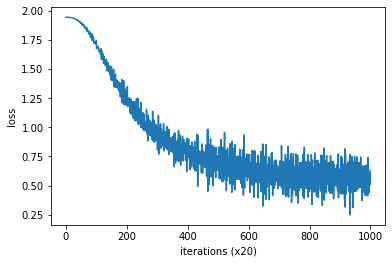

In [4]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
from common_wj.trainer import Trainer
from common_wj.optimizer import Adam
from simple_cbow import SimpleCBOW
from common_wj.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

text = "You say goodbye and I say hello."
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target,vocab_size)
contexts = convert_one_hot(contexts,vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()
#plt.show()

가로축은 학습 횟수, 세로축은 손실

학습이 경과될수록 손실이 줄어드는 것을 알 수 있다.

In [8]:
# 학습이 끝난 뒤의 가중치 매개변수
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word,word_vecs[word_id],end = '\n\n')

you [-1.0724005 -1.3093127 -1.199882   1.0076742 -1.0719963]

say [ 1.1850975  -0.05811398  0.3203912  -1.165234    1.184517  ]

goodbye [-0.70363766 -0.6534883  -0.73416054  0.8297481  -0.7647369 ]

and [ 0.90955126 -1.6680366   1.5154948  -0.927092    0.92221177]

i [-0.7178147  -0.67734104 -0.72885996  0.8220824  -0.7696292 ]

hello [-1.0614756  -1.3066372  -1.1823473   0.99743235 -1.0604573 ]

. [ 1.0904626  1.375986  -1.5999655 -1.0724356  1.0933919]



단어를 밀집벡터로 표현완료

# word2vec 보충

## CBOW 모델과 확률

사후확률 $P(A|B)$는 'B'가 주어졌을 때 A가 일어날 확률이다.

$w_1  w_2 .... w_{t-1}  w_{t}  w_{t+1} ... $

이것을 word2vec에 대입하면,

맥락 $w_{t-1}과 w_{t+1}$이 주어졌을 때 타깃이 $w_{t}$가 될 확률은 수식으로 $P(w_{t}|w_{t-1},w_{t+1})$ 으로 나타날 수 있다. 

이는 즉, $w_{t-1}$와 $w_{t+1})$가 주어졌을 때 $w_{t}$가 일어날 확률을 뜻한다. **====> CBOW**



## skip-gram 모델

skip-gram은 CBOW에서 다루는 맥락과 타깃을 역전시킨 모델이다.

CBOW 모델은 맥락이 여러 개 있고, 그 여러 맥락으로부터 중앙의 단어(타깃)을 추측한다.

``` you ? goodbye and I say hello.```

한편, skip-gram 모델은 중앙의 단어(타깃)으로부터 주변의 여러 단어(맥락)을 추측한다.

``` ? say ? and I say hello.```

---

CBOW와 반대로 skip-gram의 입력층은 하나이다. 출력층은 맥락의 수만큼 존재한다. 

<u>따라서 각 출력층에서는 개별적으로 손실을 구하고, 이 개별 손실들을 모두 더한 값을 최종 손실로 한다.</u>